## Load Base

In [341]:
from glob import glob
import os
from skimage.io import imread

def load_images(DATABASE_PATH, classes, qtd_imagens=1300):
    database = []
    
    for classe in classes:
        IMAGES_PATH = classe + '/images'

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, IMAGES_PATH, '*.png'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME[0:qtd_imagens]:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)
    
    return database

In [342]:
DATABASE_PATH = '../COVID-19_Radiography_Dataset/'

classes = ['Normal', 'COVID', 'Viral Pneumonia']

database = load_images(DATABASE_PATH, classes, qtd_imagens=1300)

In [344]:
len(database[0]), len(database[1]), len(database[2])

(1300, 1300, 1300)

## Pre Processing

In [345]:
from skimage.filters import laplace
from matplotlib import pyplot as plt
import numpy as np
import abc

In [346]:
class Imagem():
    def __init__(self, database):
        self._database = database

    def img(self, classe, indice):
        return self._database[classe][indice]
    
    @property
    def classes_lenght(self):
        return len(self._database)
    
    @property
    def indices_lenght(self):
        return len(self._database[0])

In [347]:
class ImagemDecorator(abc.ABC):
    def __init__(self, componente):
        self._componente = componente
    
    @abc.abstractmethod
    def img(self, classe, indice):
        pass

    @property
    def classes_lenght(self):
        return self._componente.classes_lenght
    
    @property
    def indices_lenght(self):
        return self._componente.indices_lenght

In [348]:
class ImagemPotencia(ImagemDecorator):

    def img(self, classe, indice):
        image_array = np.array(self._componente.img(classe, indice), dtype='float')
        
        return 1 * np.power(image_array, 0.5) 

In [349]:
class ImagemLaplace(ImagemDecorator):
   
    def img(self, classe, indice):
        img = self._componente.img(classe, indice)

        img_laplace = laplace(img.astype(np.float64))

        img_detalhada = img + (1 * img_laplace)

        img_detalhada[img_detalhada < 0] = 0
        img_detalhada[img_detalhada > 255] = 255

        return img_detalhada

In [350]:
imagem = Imagem(database)

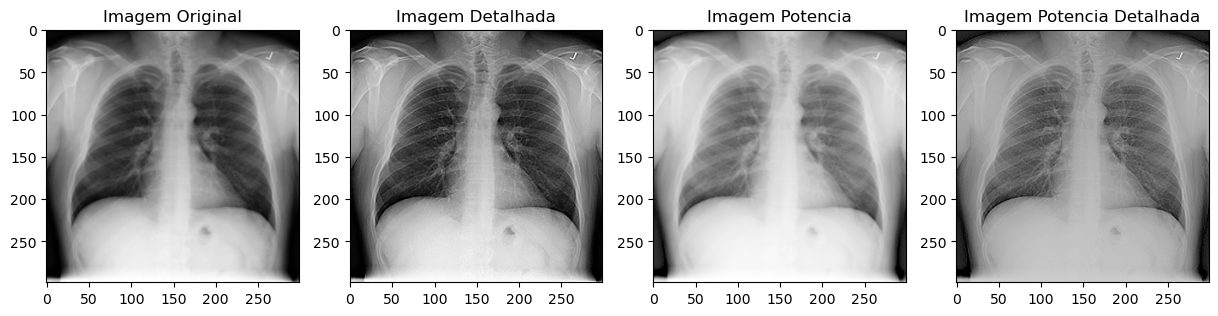

In [351]:
classe, indice = 0, 1

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 4, 1)
plt.imshow(imagem.img(classe, indice), cmap='gray')
plt.title('Imagem Original')
fig.add_subplot(1, 4, 2)
plt.imshow(ImagemLaplace(imagem).img(classe, indice), cmap='gray')
plt.title('Imagem Detalhada');
fig.add_subplot(1, 4, 3)
plt.imshow(ImagemPotencia(imagem).img(classe, indice), cmap='gray')
plt.title('Imagem Potencia')
fig.add_subplot(1, 4, 4)
plt.imshow(ImagemLaplace(ImagemPotencia(imagem)).img(classe, indice), cmap='gray')
plt.title('Imagem Potencia Detalhada');


## Segmentation

In [352]:
from skimage.filters import threshold_otsu

In [353]:
class ImagemSegmentation(ImagemDecorator):
    
    def segmentacao(self, classe, indice):
        img = self._componente.img(classe, indice)
        
        otsu = threshold_otsu(img)
        otsu_img = img > otsu

        return otsu_img.astype(np.int64)
    
    def img(self, classe, indice):
        return self._componente.img(classe, indice) * (1 - self.segmentacao(classe, indice))

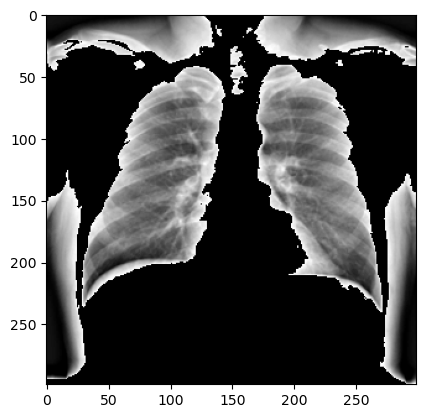

In [354]:
classe, indice = 0, 1

plt.imshow(ImagemSegmentation(imagem).img(classe, indice), cmap='gray')

In [356]:
imagem_pre_processada = ImagemLaplace(imagem)

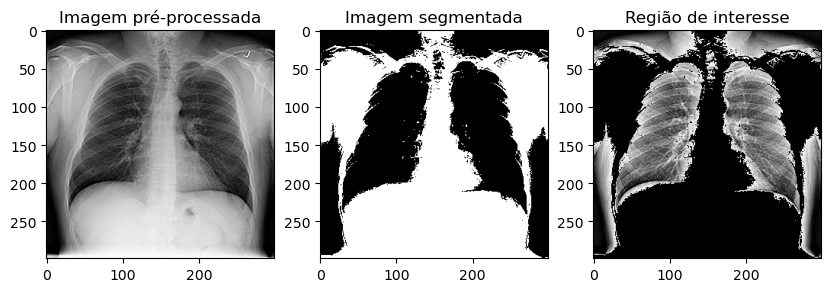

In [358]:
fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(imagem_pre_processada.img(classe, indice), cmap='gray')
plt.title('Imagem pré-processada')
fig.add_subplot(1, 3, 2)
plt.imshow(ImagemSegmentation(imagem_pre_processada).segmentacao(classe, indice), cmap='gray')
plt.title('Imagem segmentada')
fig.add_subplot(1, 3, 3)
plt.imshow(ImagemSegmentation(imagem_pre_processada).img(classe, indice), cmap='gray')
plt.title('Região de interesse');


## Descriptors

In [359]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis
from skimage.feature import graycomatrix, graycoprops


def energy(x):
    return np.sum(np.power(x, 2))

In [360]:
classe, indice = 0, 1

In [362]:
class Descritores():
    def __init__(self, componente):
        self._componente = componente

    def first(self, classe, indice):
        frequencias, _ = np.histogram(self._componente.img(classe, indice), bins=256, density=True)

        media = np.mean(frequencias)

        var = np.var(frequencias)

        sk = skew(frequencias)

        kur = kurtosis(frequencias)

        ener = energy(frequencias)

        entr = entropy(frequencias)

        return [media,var,sk,kur,ener,entr]
    
    def second(self, classe, indice):
        glcm = graycomatrix(self._componente.img(classe, indice).astype(np.int64), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
        contrast = graycoprops(glcm, 'contrast')

        dissimilarity = graycoprops(glcm, 'dissimilarity')

        homogeneity = graycoprops(glcm, 'homogeneity')

        ASM = graycoprops(glcm, 'ASM')

        energy = graycoprops(glcm, 'energy')
        
        correlation = graycoprops(glcm, 'correlation')
        
        return [contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0]]
    
    def x_y_split(self, tipo='first'):
        x = []
        y = []

        descritor_function = self.first
        if tipo.lower() == 'second':
            descritor_function = self.second

        classes = self._componente.classes_lenght
        indices = self._componente.indices_lenght

        for classe in range(classes):
            for indice in range(indices):
                x.append(descritor_function(classe, indice))
                y.append(classe)

        return x, y

In [367]:
descritores = Descritores(imagem)

In [368]:
print(descritores.first(classe, indice))
print(descritores.second(classe, indice))

[0.004, 2.4234120969893305e-06, -0.498311747524521, -0.035521594677382584, 0.004716393496829268, 5.45267093969021]
[22.540021548337865, 2.977520145451281, 0.367745531099122, 0.0005114555853060566, 0.022615383819560894, 0.9973493911103907]


## Classification

In [369]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV

In [370]:
metrics = ['accuracy', 'f1_weighted', 'jaccard_weighted']

In [371]:
def print_metricas(scores):
    print('Acuracia: {} (+/- {})'.format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()) )
    print('F1: {} (+/- {})'.format(scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()) )
    print('Jaccard: {} (+/- {})'.format(scores['test_jaccard_weighted'].mean(), scores['test_jaccard_weighted'].std()) )

### Grid Search

In [372]:
x, y = descritores.x_y_split()

Random Forest

In [373]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'n_jobs': [-1]}

In [374]:
rf = RandomForestClassifier()

grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid.fit(x, y)

print(grid.best_params_)

{'max_depth': 10, 'n_estimators': 400, 'n_jobs': -1}


In [375]:
rf.set_params(**grid.best_params_)

RandomForestClassifier(max_depth=10, n_estimators=400, n_jobs=-1)

In [376]:
scores = cross_validate(rf, x, y, cv=5, scoring=metrics)

In [377]:
scores

{'fit_time': array([0.6216433 , 0.61847186, 0.62860823, 0.56127644, 0.55320716]),
 'score_time': array([0.15496397, 0.14494538, 0.15794277, 0.12894607, 0.12894964]),
 'test_accuracy': array([0.57564103, 0.63076923, 0.67948718, 0.65897436, 0.68974359]),
 'test_f1_weighted': array([0.57319504, 0.62999428, 0.67855142, 0.65947261, 0.68852225]),
 'test_jaccard_weighted': array([0.40276553, 0.46163917, 0.51386904, 0.49362603, 0.5265487 ])}

In [378]:
print_metricas(scores)

Acuracia: 0.6469230769230769 (+/- 0.0409422228845376)
F1: 0.6459471186740988 (+/- 0.0414872985336309)
Jaccard: 0.47968969456716903 (+/- 0.044274967221812046)


MLP

In [379]:
param_grid = {'hidden_layer_sizes': [(100,), (200,), (300,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'max_iter': [100, 200, 300]}

In [380]:
clf = mlp()

grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid.fit(x, y)

grid.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 300}

In [381]:
clf.set_params(**grid.best_params_)

MLPClassifier(max_iter=300)

In [382]:
scores = cross_validate(clf, x, y, cv=5, scoring=metrics)

In [383]:
scores

{'fit_time': array([1.06902742, 1.85118651, 1.58372545, 1.43129921, 1.48914766]),
 'score_time': array([0.01099443, 0.00899363, 0.00999427, 0.00999475, 0.00792503]),
 'test_accuracy': array([0.44487179, 0.47820513, 0.50897436, 0.5025641 , 0.56410256]),
 'test_f1_weighted': array([0.37095658, 0.4700094 , 0.47136263, 0.49625498, 0.56006562]),
 'test_jaccard_weighted': array([0.2497619 , 0.31914408, 0.31709136, 0.33241488, 0.39031486])}

In [384]:
print_metricas(scores)

Acuracia: 0.49974358974358973 (+/- 0.039268458517231444)
F1: 0.4737298404413866 (+/- 0.06089833529548064)
Jaccard: 0.3217454160971534 (+/- 0.04477869736621108)


### Resultados

In [333]:
imagem = Imagem(database)
imagem_laplace = ImagemLaplace(imagem)
imagem_potencia_laplace = ImagemLaplace(ImagemPotencia(imagem))

segmentacao_laplace = ImagemSegmentation(imagem_laplace)
segmentacao_potencia_laplace = ImagemSegmentation(imagem_potencia_laplace)

descritores_laplace = Descritores(segmentacao_laplace)
descritores_potencia_laplace = Descritores(segmentacao_potencia_laplace)

In [389]:
for nome_preprocessamento, descritores in {'Laplace': descritores_laplace, 'Potencia Laplace': descritores_potencia_laplace}.items():
    for tipo in ('first', 'second'):
        x, y = descritores.x_y_split(tipo)
        for nome_classificador, classificador in {'Random Forest': rf, 'MLP': clf}.items():
            print(nome_preprocessamento, tipo, nome_classificador, end='\n\n')
            print_metricas(cross_validate(classificador, x, y, cv=5, scoring=metrics))
            print()

Laplace first Random Forest

Acuracia: 0.6448717948717949 (+/- 0.037228084949500584)
F1: 0.6452783695237637 (+/- 0.0369618531590556)
Jaccard: 0.4792138085719574 (+/- 0.038412811443160534)

Laplace first MLP

Acuracia: 0.4884615384615385 (+/- 0.0605855712182547)
F1: 0.41624505186290434 (+/- 0.09099130945655273)
Jaccard: 0.2917346329719466 (+/- 0.06981696135838535)

Laplace second Random Forest

Acuracia: 0.6923076923076923 (+/- 0.012973446810947217)
F1: 0.69308343579275 (+/- 0.012429975748182179)
Jaccard: 0.5333781796014329 (+/- 0.013159616867379889)

Laplace second MLP

Acuracia: 0.5194871794871795 (+/- 0.04947721435471516)
F1: 0.5015330372792202 (+/- 0.05453424195507663)
Jaccard: 0.34029174388672845 (+/- 0.04952989585198042)

Potencia Laplace first Random Forest

Acuracia: 0.6187179487179486 (+/- 0.044312262347411535)
F1: 0.6197436951558519 (+/- 0.043354762176357954)
Jaccard: 0.4526598306141345 (+/- 0.04244570809190409)

Potencia Laplace first MLP

Acuracia: 0.4915384615384615 (+/- 0.

e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Acuracia: 0.5956410256410256 (+/- 0.03796777068491617)
F1: 0.5934359920706898 (+/- 0.040685050537169136)
Jaccard: 0.427694680587088 (+/- 0.03555633240931316)



In [392]:
imagem = Imagem(database)
imagem_laplace = ImagemLaplace(imagem)
imagem_potencia = ImagemPotencia(imagem)
imagem_potencia_laplace = ImagemLaplace(ImagemPotencia(imagem))

descritores_laplace = Descritores(imagem_potencia)
descritores_potencia = Descritores(imagem_potencia)
descritores_potencia_laplace = Descritores(imagem_potencia_laplace)

In [393]:
rf = RandomForestClassifier()
clf = mlp()

In [394]:
for nome_preprocessamento, descritores in {'Laplace': descritores_laplace, 'Potencia': descritores_potencia, 'Potencia Laplace': descritores_potencia_laplace}.items():
    for tipo in ('first', 'second'):
        x, y = descritores.x_y_split(tipo)
        for nome_classificador, classificador in {'Random Forest': rf, 'MLP': clf}.items():
            print(nome_preprocessamento, tipo, nome_classificador, end='\n\n')
            print_metricas(cross_validate(classificador, x, y, cv=5, scoring=metrics))
            print()

Laplace first Random Forest

Acuracia: 0.6328205128205129 (+/- 0.03772456320882344)
F1: 0.6321109767811739 (+/- 0.038719893525294986)
Jaccard: 0.46431214314281444 (+/- 0.04090529928262077)

Laplace first MLP

Acuracia: 0.6146153846153846 (+/- 0.03947885360109642)
F1: 0.6140624442103156 (+/- 0.04002387442333552)
Jaccard: 0.4451687055210293 (+/- 0.04078551310740832)

Laplace second Random Forest

Acuracia: 0.7161538461538461 (+/- 0.02855954481890397)
F1: 0.7159865651004609 (+/- 0.027462103145826294)
Jaccard: 0.5604318213152799 (+/- 0.03315680433339734)

Laplace second MLP



e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

Acuracia: 0.6415384615384616 (+/- 0.03717152876804127)
F1: 0.6387654356823631 (+/- 0.03889597537760391)
Jaccard: 0.47410374559227525 (+/- 0.0387562837885239)

Potencia first Random Forest

Acuracia: 0.6361538461538462 (+/- 0.03781855709849983)
F1: 0.6356535440140719 (+/- 0.03865790747183417)
Jaccard: 0.4679287405699452 (+/- 0.04111654124319101)

Potencia first MLP

Acuracia: 0.6107692307692307 (+/- 0.043722272137525636)
F1: 0.6105291543721549 (+/- 0.04402555352192498)
Jaccard: 0.4415693878051609 (+/- 0.04457446905732719)

Potencia second Random Forest

Acuracia: 0.7264102564102564 (+/- 0.03342787382098923)
F1: 0.7262723611888451 (+/- 0.03268101528385276)
Jaccard: 0.5730821261883435 (+/- 0.0399868846610913)

Potencia second MLP



e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

Acuracia: 0.6464102564102564 (+/- 0.036867836169929044)
F1: 0.6449532254363801 (+/- 0.03698053843862255)
Jaccard: 0.4800069281355607 (+/- 0.0387926441983361)

Potencia Laplace first Random Forest

Acuracia: 0.6582051282051282 (+/- 0.03173277641929225)
F1: 0.6577541181617792 (+/- 0.03070863426957395)
Jaccard: 0.4940920836452336 (+/- 0.032306217756232304)

Potencia Laplace first MLP

Acuracia: 0.6366666666666666 (+/- 0.02215538930997739)
F1: 0.6357587923193809 (+/- 0.022877085732386292)
Jaccard: 0.46772483921478936 (+/- 0.024217396728702052)

Potencia Laplace second Random Forest

Acuracia: 0.7441025641025641 (+/- 0.02648110983649013)
F1: 0.7439086018196724 (+/- 0.02594860916500775)
Jaccard: 0.5950941490661147 (+/- 0.03319970979368591)

Potencia Laplace second MLP



e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acuracia: 0.6810256410256411 (+/- 0.031334550314189996)
F1: 0.6754279423896656 (+/- 0.03748133069374985)
Jaccard: 0.5170947140124958 (+/- 0.033368655164383226)



e:\conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
